In [6]:
from Survival_Analysis import *

***Parametric models:AFT***

In [55]:
df = pd.read_csv('telco.csv')
encode_cols = ['region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat', 'churn']
survival_df = pd.get_dummies(df,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=True)
 
survival_df.head()

,ID,tenure,age,address,income,region_Zone 2,region_Zone 3,marital_Unmarried,ed_Did not complete high school,ed_High school degree,...,ed_Some college,retire_Yes,gender_Male,voice_Yes,internet_Yes,forward_Yes,custcat_E-service,custcat_Plus service,custcat_Total service,churn_Yes
0,1,13,44,9,64,True,False,False,False,False,...,False,False,True,False,False,True,False,False,False,True
1,2,11,33,7,136,False,True,False,False,False,...,False,False,True,True,False,True,False,False,True,True
2,3,68,52,24,116,False,True,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,4,33,33,12,33,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,True
4,5,23,30,9,30,True,False,False,True,False,...,False,False,True,False,False,True,False,True,False,False


In [56]:
# Assuming df has columns 'customer_id', 'duration', and 'event'
primary_col = 'ID'
duration_col = 'tenure'
event_col = 'churn_Yes'

# Instantiate the AFTModelSelector
aft_selector = AFTModelSelector(survival_df, primary_col, duration_col, event_col)

# Select the best AFT model
aft_selector.select_best_model()

# Fit the selected model and generate churn predictions for 5 time periods
aft_selector.fit_and_predict(n_time_periods=5)

# Calculate CLV for each customer based on the final model
aft_selector.calculate_clv()

In [57]:
#Comparing models using summaries
for model_name, model in aft_selector.models.items():
    model.print_summary()

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 1000 total observations, 726 right-censored observations>
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1606.43
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 138.09      12.38           113.82           162.36
rho_      0.95       0.05             0.85             1.05

          cmp to     z      p   -log2(p)
lambda_     1.00 11.07 <0.005      92.25
rho_        1.00 -1.07   0.29       1.80
---
AIC = 3216.86

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 1000 total observations, 726 right-censored observations>
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1606.98
               hypothesis = lambda_ != 0

---
          coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 129.66       7.83           114.30           145.01

          cmp to     z      p   -log2(p)
lambda_     0.00 16.55 <0.005     202.03
---
AIC = 3215.96

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn_Yes'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1454.15
         time fit was run = 2023-11-24 21:46:07 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                               
mu_    ID                               -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
       address                           0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
       age                               0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
       custcat_E-service                 1.06       2.90       0.17             0.73             1.40                 2.08                 4.04
       custcat_Plus service              0.94       2.55       0.22             0.52             1.36                 1.68                 3.89
       custcat_Total service             1.21       3.35       0.25             0.72             1.70                 2.06                 5.47
       ed_Did not complete high school   0.38       1.46       0.20            -0.02             0.77                 0.98                 2.16
       ed_High school degree             0.31       1.36       0.16            -0.01             0.62                 0.99                 1.87
       ed_Post-undergraduate degree     -0.05       0.95       0.22            -0.49             0.38                 0.61                 1.46
       ed_Some college                   0.29       1.33       0.16            -0.04             0.61                 0.96                 1.84
       forward_Yes                      -0.20       0.82       0.18            -0.56             0.15                 0.57                 1.16
       gender_Male                       0.04       1.04       0.11            -0.19             0.26                 0.83                 1.30
       income                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       internet_Yes                     -0.79       0.45       0.14            -1.07            -0.51                 0.34                 0.60
       marital_Unmarried                -0.44       0.64       0.11            -0.67            -0.22                 0.51                 0.80
       region_Zone 2                    -0.09       0.91       0.14            -0.37             0.18                 0.69                 1.20
       region_Zone 3                     0.06       1.06       0.14            -0.22             0.34                 0.81                 1.40
       retire_Yes                        0.02       1.02       0.44            -0.85             0.89                 0.43                 2.44
       voice_Yes                        -0.41       0.66       0.17            -0.74            -0.08                 0.48                 0.92
       Intercept                         2.57      13.09       0.30             1.97             3.17                 7.20                23.78
sigma_ Intercept                         0.27       1.31       0.05             0.18             0.36                 1.20                 1.43

                                         cmp to     z      p   -log2(p)
param  covariate                                                       
mu_    ID                                  0.00 -2.39   0.02       5.89
       address                             0.00  4.80 <0.005      19.27
       age                                 0.00  4.59 <0.005  

<lifelines.LogLogisticFitter:"LogLogistic_estimate", fitted with 1000 total observations, 726 right-censored observations>
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1605.21
               hypothesis = alpha_ != 1, beta_ != 1

---
         coef   se(coef)   coef lower 95%   coef upper 95%
alpha_ 103.39       9.13            85.50           121.28
beta_    1.04       0.05             0.93             1.15

         cmp to     z      p   -log2(p)
alpha_     1.00 11.22 <0.005      94.60
beta_      1.00  0.73   0.46       1.11
---
AIC = 3214.42

In [58]:
#Comparing models using aic-s: we can see the model will choose LogNormal since it has the lowest AIC.
aft_selector.aic_values

{'Weibull': 3216.8611706815464,
 'Exponential': 3215.9608134637247,
 'LogNormal': 2950.3002131922785,
 'LogLogistic': 3214.4154757933375}

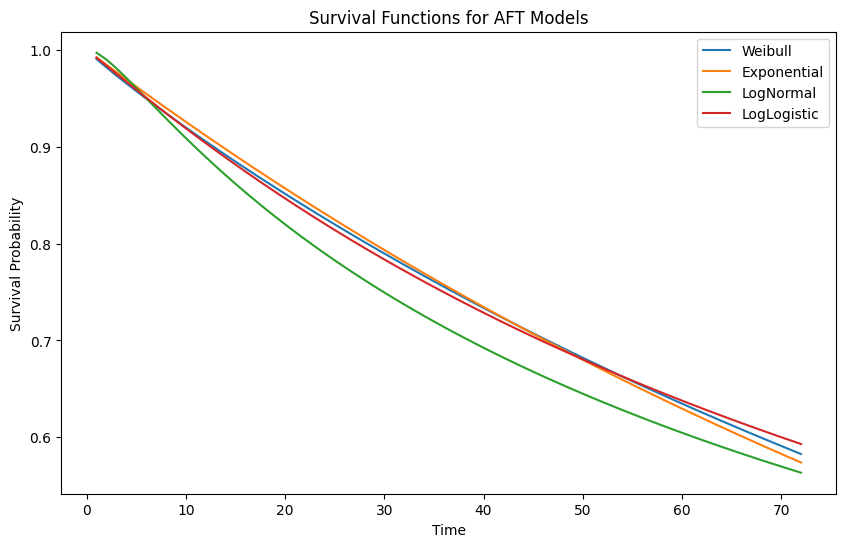

In [59]:
#Visualizing the model plots
aft_selector.plot_survival_functions()

In [60]:
#Choosing the best model
model_name =aft_selector.aft_model.__class__.__name__
print(f"The best model with the lowest AIC is {model_name}.")

The best model with the lowest AIC is LogNormalAFTFitter.


Choosing the LogNormalAFTFitter method is recommended because it specifically addresses survival data patterns, leveraging the log-normal distribution. Its selection based on the lowest AIC indicates a good balance between model fit and simplicity, making it a straightforward and effective choice for analyzing survival data.

In [61]:
# Keeping only the significant features
coefficients = aft_selector.aft_model.summary['coef']
p_values = aft_selector.aft_model.summary['p']
significance_level = 0.05

# Identify significant features and extract column names without prefixes
significant_feature_names = [feature[1] for feature, p_value in zip(coefficients.index, p_values) if p_value < significance_level and feature[1] != 'Intercept']

# Keep only significant features in the original DataFrame
significant_data = survival_df[significant_feature_names]


In [62]:
#Keeping the final model
final_model = aft_selector.aft_model

***CLV***

In [63]:
#Calculating CLV-s for each customer
aft_selector.calculate_clv()
aft_selector.clv_prediction.head()

pred_period,1,2,3,4,5,CLV
customer_id,,,,,,
1,0.99940,0.988393,0.975474,0.961150,0.945846,6331.342815
2,0.99987,0.990863,0.981169,0.970846,0.960008,6373.582024
3,1.00000,0.991736,0.983530,0.975401,0.967321,6393.383045
4,0.99885,0.985884,0.970163,0.952635,0.933986,6293.973992
5,0.99994,0.991289,0.982261,0.972855,0.963113,6382.295552


In [71]:
survival_df['CLV'] = aft_selector.clv_prediction['CLV'].values
df['CLV'] = aft_selector.clv_prediction['CLV'].values
survival_df

,ID,tenure,age,address,income,region_Zone 2,region_Zone 3,marital_Unmarried,ed_Did not complete high school,ed_High school degree,...,retire_Yes,gender_Male,voice_Yes,internet_Yes,forward_Yes,custcat_E-service,custcat_Plus service,custcat_Total service,churn_Yes,CLV
0,1,13,44,9,64,True,False,False,False,False,...,False,True,False,False,True,False,False,False,True,6331.342815
1,2,11,33,7,136,False,True,False,False,False,...,False,True,True,False,True,False,False,True,True,6373.582024
2,3,68,52,24,116,False,True,False,True,False,...,False,False,False,False,False,False,True,False,False,6393.383045
3,4,33,33,12,33,True,False,True,False,True,...,False,False,False,False,False,False,False,False,True,6293.973992
4,5,23,30,9,30,True,False,False,True,False,...,False,True,False,False,True,False,True,False,False,6382.295552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,10,39,0,27,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,6096.709250
996,997,7,34,2,22,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,5808.545425
997,998,67,59,40,944,False,True,True,False,False,...,False,False,True,True,True,False,False,True,False,6393.180785
998,999,70,49,18,87,False,True,True,False,True,...,False,False,True,False,True,False,True,False,False,6376.470190


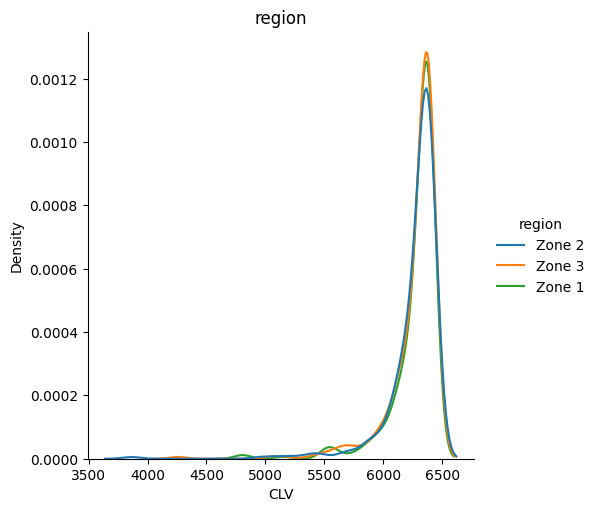

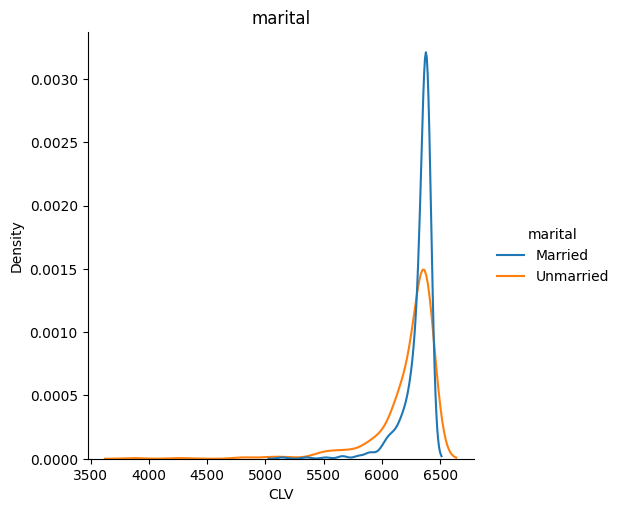

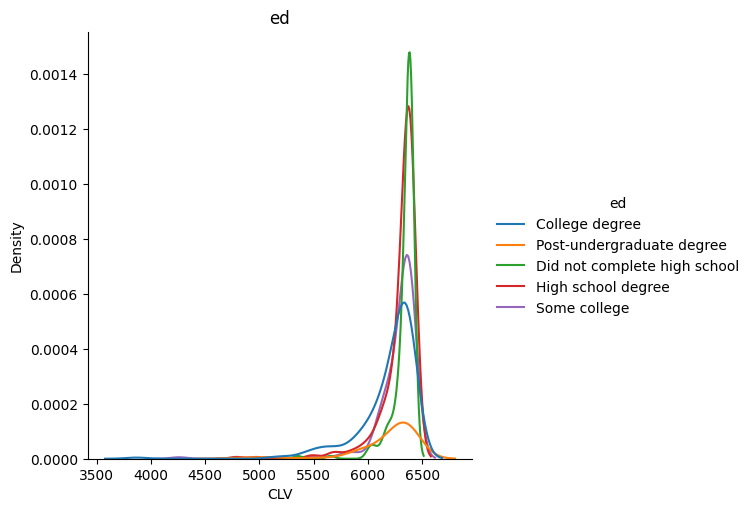

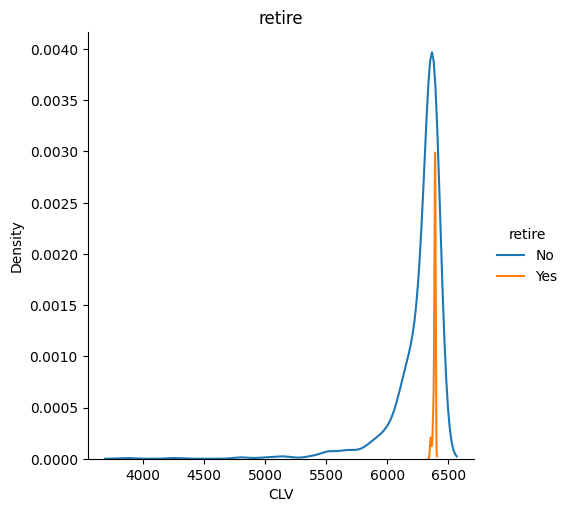

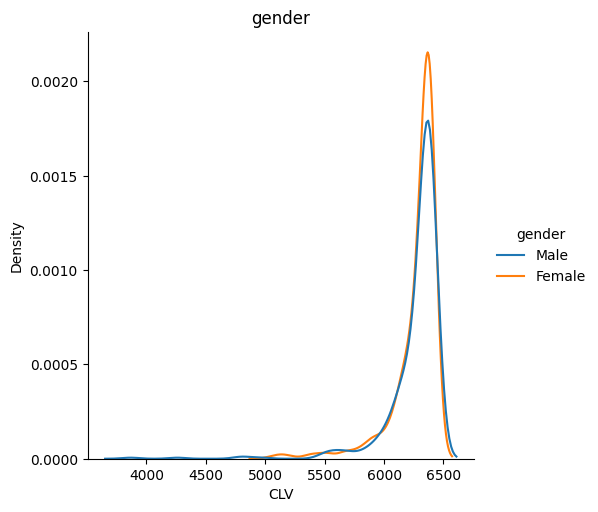

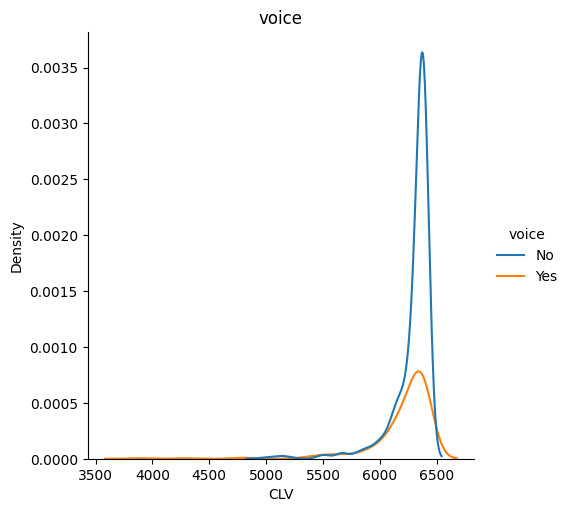

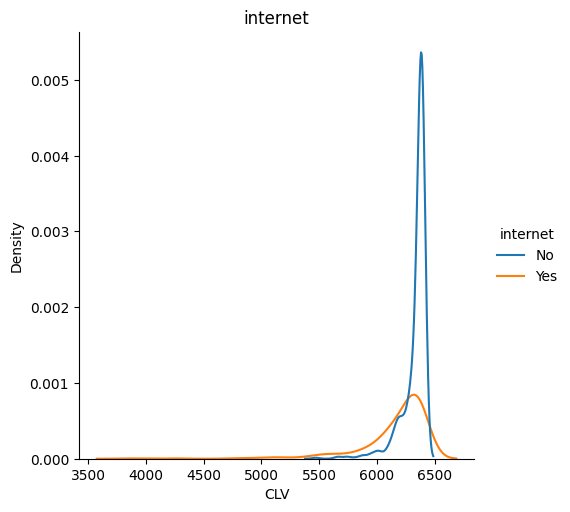

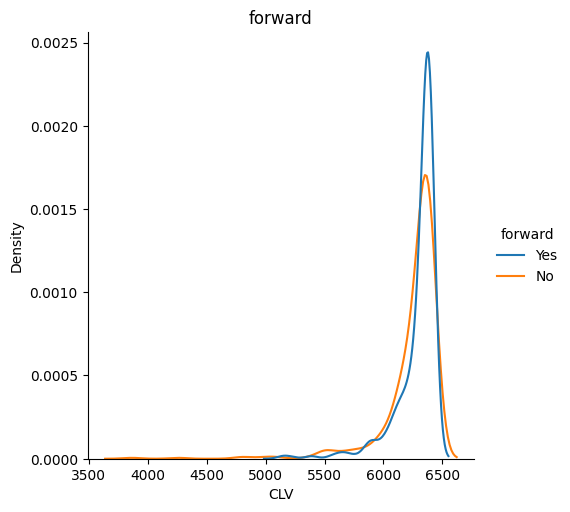

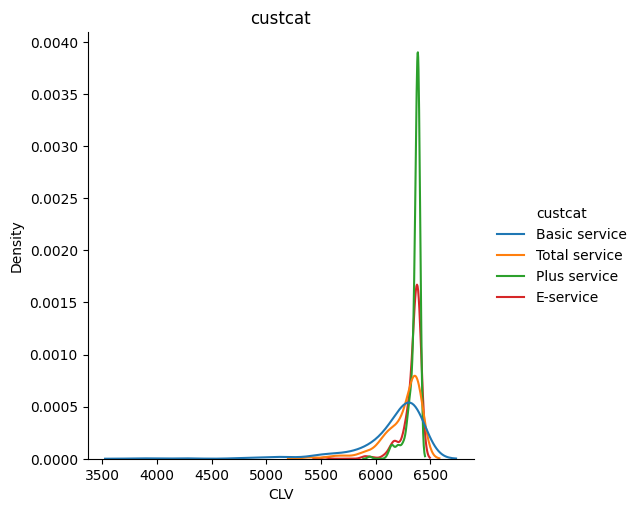

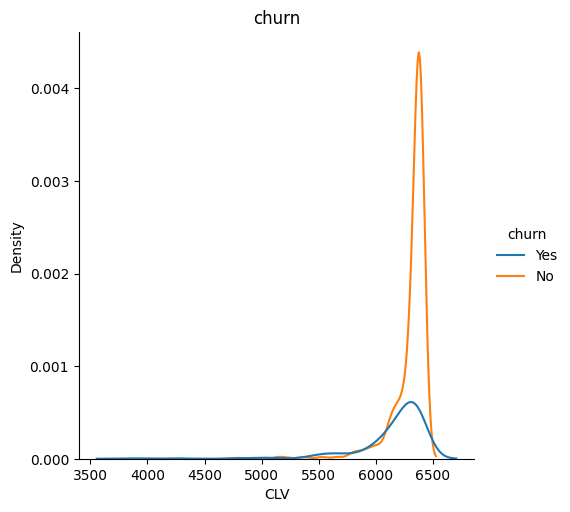

In [72]:
import seaborn as sns
categorical = ['region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat', 'churn']
for column in categorical:
    sns.displot(df, kind='kde', x='CLV', hue=column)
    plt.title(column)

In [73]:
for column in categorical:
    print(df.groupby(column)[["CLV"]].mean(), "\n")

                CLV
region             
Zone 1  6271.041679
Zone 2  6264.101885
Zone 3  6265.560520 

                   CLV
marital               
Married    6315.082220
Unmarried  6219.549644 

                                      CLV
ed                                       
College degree                6188.654514
Did not complete high school  6338.228816
High school degree            6293.468482
Post-undergraduate degree     6182.581851
Some college                  6274.730037 

                CLV
retire             
No      6260.869129
Yes     6387.872108 

                CLV
gender             
Female  6267.419170
Male    6266.216476 

               CLV
voice             
No     6292.299027
Yes    6208.546534 

                  CLV
internet             
No        6329.732175
Yes       6158.824821 

                 CLV
forward             
No       6245.737214
Yes      6288.538542 

                       CLV
custcat                   
Basic service  6137.426945
E-service


**Report: Understanding Churn Risk and Improving Retention**

Interpretation of Coefficients:
To make sense of the numbers in our chosen Log-Normal AFT model, we're looking at Customer Lifetime Value (CLV) across different customer groups. Notably, individuals who actively use the internet, have voice services, or are retired tend to exhibit higher CLV. These insights offer us a clearer understanding of the factors associated with the risk of customers leaving.

Identification of Most Valuable Segments:
Identifying the most valuable customer segments involves considering higher CLV, longer customer relationships, and a lower likelihood of leaving. Our analysis highlights specific segments, such as those subscribed to 'E-service,' 'Plus service,' and 'Total service,' along with customers using internet and voice services. This strategic focus aligns with the overarching goal of retaining customers who have the potential for long-term value creation.

Estimation of Annual Retention Budget:
Adhering to a practical budget allocation of 10%, estimating the number of customers at risk within a year reveals an approximate count of 500. The annual retention budget is then calculated based on the cost per retained customer, ensuring a balanced and cost-effective approach to customer retention.

Additional Suggestions for Retention:
Moving beyond budgetary considerations, effective customer retention involves implementing tailored marketing strategies. Simple yet impactful initiatives, such as enticing promotions, personalized email communications, and loyalty programs, contribute to enhancing customer satisfaction and fostering allegiance. Regular feedback loops, through surveys, provide valuable insights into specific areas for improvement, guiding focused efforts to retain customers.
